# VAR India

Vector auto-regressive models - VAR, VMA, VARIMA on Covid-19 Cases. For all models, the first-differenced dataset is used (I = 1).

## [Setup](#setup)
1. [Imports](#imports)
2. [Results table](#results_init)
3. [Ingestion](#ingestion)
4. [Plotting](#plotting_init)
5. [Statistical tests](#stattests1)
    1. [Johansen co-integration test](#jci_init)
    2. [Augmented DF Test](#adf_init)
6. [Differencing](#diff_init)
7. [Train test split](#traintest_init)

## Long-Term Forecasting

### [VAR Model](#var_model)
1. [Find order p of VAR](#var_p)
2. [VAR(1) Model](#var1)
3. [Plots of first differenced predictions](#diff_plot_var)
4. [Undifferencing and plotting](#undiff_var)
5. [Store metrics - MAE, MAPE, MSE](#store_var)
6. [Plot Train, Test, Forecast](#plot_final_var)

    
### [VMA Model](#vma_model)
1. [Find order q of VMA](#vma_q)
2. [VMA(1) Model](#vma1)
3. [Plots of first differenced predictions](#diff_plot_vma)
4. [Undifferencing and plotting](#undiff_vma)
5. [Store metrics - MAE, MAPE, MSE](#store_vma)
6. [Plot Train, Test, Forecast](#plot_final_vma)


### [VARMA Model](#varma_model)
1. [Find order (p, q) of VARMA](#varma_pq)
2. [VARMA(1, 1) Model](#varma11)
3. [Plots of first differenced predictions](#diff_plot_varma)
4. [Undifferencing and plotting](#undiff_varma)
5. [Store metrics - MAE, MAPE, MSE](#store_varma)
6. [Plot Train, Test, Forecast](#plot_final_varma)

## [Short-Term/Rolling Forecasting](#shortterm)

1. [VAR(1)](#var_roll)
2. [VMA(1)](#vma_roll)
3. [VARMA(1,1)](#varma_roll)

## [Final Metrics](#final_results)

<a name=setup></a>

# Setup

<a name=imports></a>
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

<a name=results_init></a>
## Results table

In [2]:
results_columns = ['model', 'mse', 'mape', 'mae']
results_table = pd.DataFrame(columns=results_columns)

<a name=ingestion></a>

## Ingestion

In [3]:
daily_cases_india = pd.read_csv('../../cleaned_datasets/india/daily_cases_india.csv', parse_dates=['Date'])
daily_vacc_india = pd.read_csv('../../cleaned_datasets/india/daily_vacc_india.csv', parse_dates=['date'])

In [4]:
daily_cases_india.dtypes

Date         datetime64[ns]
Confirmed           float64
Deaths              float64
Recovered           float64
dtype: object

In [5]:
daily_cases_india

,Date,Confirmed,Deaths,Recovered
0,2020-01-30,NaN,NaN,NaN
1,2020-01-31,0.0,0.0,0.0
2,2020-02-01,0.0,0.0,0.0
3,2020-02-02,1.0,0.0,0.0
4,2020-02-03,1.0,0.0,0.0
...,...,...,...,...
707,2022-01-06,117100.0,302.0,0.0
708,2022-01-07,141986.0,285.0,0.0
709,2022-01-08,159632.0,327.0,0.0
710,2022-01-09,179723.0,146.0,0.0


In [6]:
daily_vacc_india.dtypes

date           datetime64[ns]
Total_Doses           float64
dtype: object

In [7]:
daily_vacc_india

,date,Total_Doses
0,2021-01-15,NaN
1,2021-01-16,NaN
2,2021-01-17,33120.0
3,2021-01-18,229748.0
4,2021-01-19,220786.0
...,...,...
345,2022-01-06,9787059.0
346,2022-01-07,13600889.0
347,2022-01-08,2415504.0
348,2022-01-09,9697867.0


In [8]:
cases_vacc = daily_cases_india.merge(daily_vacc_india, how='outer', left_on='Date', right_on='date')
cases_vacc = cases_vacc[["Date", "Confirmed", "Total_Doses"]]
cases_vacc

,Date,Confirmed,Total_Doses
0,2020-01-30,NaN,NaN
1,2020-01-31,0.0,NaN
2,2020-02-01,0.0,NaN
3,2020-02-02,1.0,NaN
4,2020-02-03,1.0,NaN
...,...,...,...
707,2022-01-06,117100.0,9787059.0
708,2022-01-07,141986.0,13600889.0
709,2022-01-08,159632.0,2415504.0
710,2022-01-09,179723.0,9697867.0


In [9]:
cases_vacc.fillna(0, inplace=True)
indexed = cases_vacc.set_index('Date')
indexed

,Confirmed,Total_Doses
Date,,
2020-01-30,0.0,0.0
2020-01-31,0.0,0.0
2020-02-01,0.0,0.0
2020-02-02,1.0,0.0
2020-02-03,1.0,0.0
...,...,...
2022-01-06,117100.0,9787059.0
2022-01-07,141986.0,13600889.0
2022-01-08,159632.0,2415504.0


<a name=plotting_init></a>
## Plot initial data

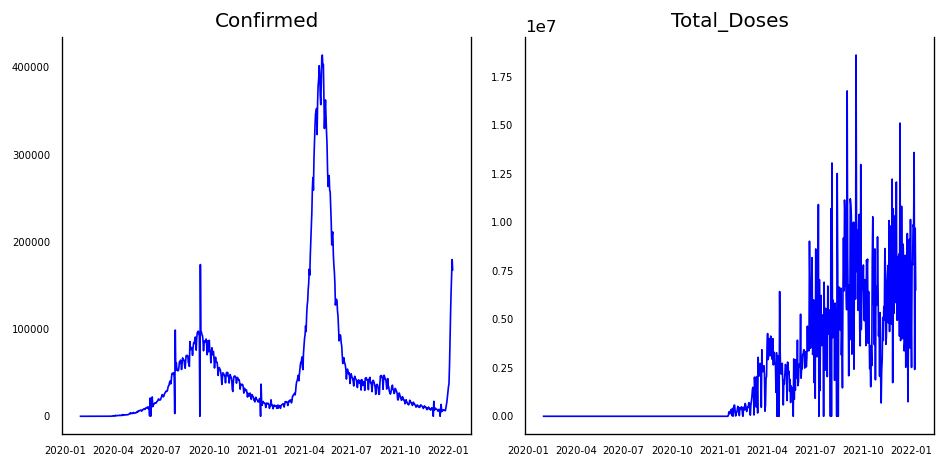

In [10]:
plot_2col_subplots(indexed)

<a name=stattests1></a>
## Statistical tests

<a name=jci_init></a>

### Johansen co-integration test

In [11]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(indexed)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  5.14      > 12.3212   =>   False
Total_Doses ::  0.18      > 4.1296    =>   False


From JCT, the two time series are not correlated.

<a name=adf_init></a>

### Augmented DF Test

In [12]:
from statsmodels.tsa.stattools import adfuller

def run_dicky_fuller(ts):
  '''Function to run Augmented Dicky Fuller test on the passed time series and report the statistics from the test'''
  print("Observations of Dickey-fuller test")
  dftest = adfuller(ts,autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])

  for key,value in dftest[4].items():
      dfoutput['critical value (%s)'%key]= value
  print(dfoutput)


# ADF Test on each column
for name, column in indexed.iteritems():
    run_dicky_fuller(column)
    print('\n')

Observations of Dickey-fuller test
Test Statistic                  -3.015566
p-value                          0.033466
#lags used                      15.000000
number of observations used    696.000000
critical value (1%)             -3.439780
critical value (5%)             -2.865702
critical value (10%)            -2.568986
dtype: float64


Observations of Dickey-fuller test
Test Statistic                  -0.546957
p-value                          0.882523
#lags used                      11.000000
number of observations used    700.000000
critical value (1%)             -3.439726
critical value (5%)             -2.865678
critical value (10%)            -2.568973
dtype: float64




The TS is not stationary

<a name=diff_init></a>
## Differencing

## First order differencing

In [13]:
df_diff_1 = indexed.diff().dropna()
df_diff_1

,Confirmed,Total_Doses
Date,,
2020-01-31,0.0,0.0
2020-02-01,0.0,0.0
2020-02-02,1.0,0.0
2020-02-03,0.0,0.0
2020-02-04,-1.0,0.0
...,...,...
2022-01-06,26172.0,-86635.0
2022-01-07,24886.0,3813830.0
2022-01-08,17646.0,-11185385.0


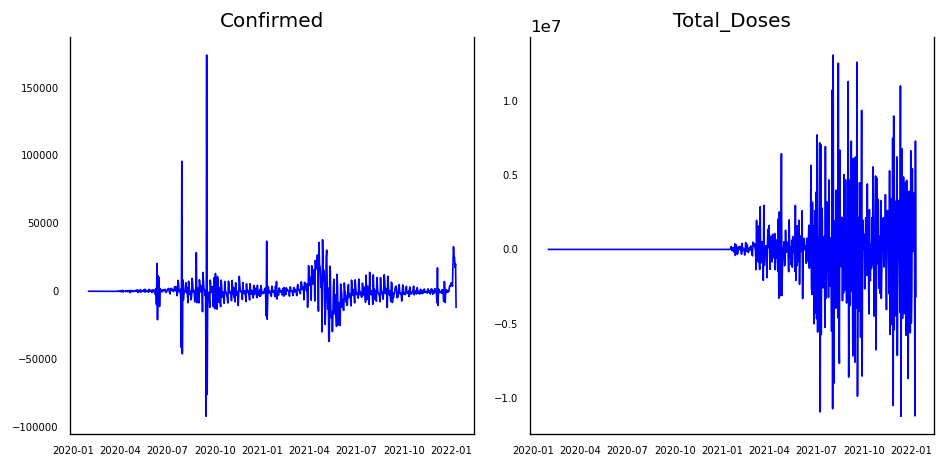

In [14]:
plot_2col_subplots(df_diff_1)


In [15]:
# ADF Test on each column
for name, column in df_diff_1.iteritems():
    run_dicky_fuller(column)
    print('\n')

Observations of Dickey-fuller test
Test Statistic                  -3.591903
p-value                          0.005918
#lags used                      19.000000
number of observations used    691.000000
critical value (1%)             -3.439849
critical value (5%)             -2.865732
critical value (10%)            -2.569002
dtype: float64


Observations of Dickey-fuller test
Test Statistic                -1.313711e+01
p-value                        1.454548e-24
#lags used                     1.000000e+01
number of observations used    7.000000e+02
critical value (1%)           -3.439726e+00
critical value (5%)           -2.865678e+00
critical value (10%)          -2.568973e+00
dtype: float64




In [16]:
cointegration_test(df_diff_1)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  362.76    > 12.3212   =>   True
Total_Doses ::  64.8      > 4.1296    =>   True


From JCT, the two time series are correlated.

<a name=traintest_init></a>
## Train-test split

### Train-test split - first order differenced

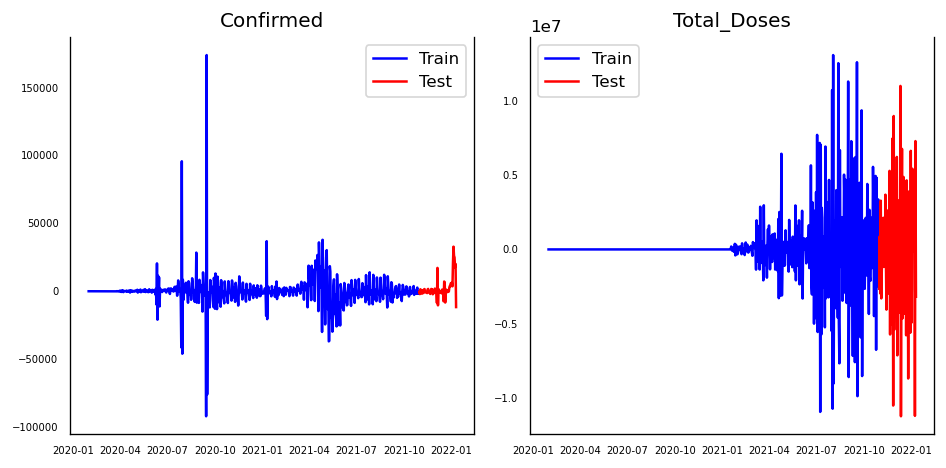

In [17]:
percent_90 = int(len(df_diff_1)*0.9)

train = df_diff_1.iloc[:percent_90].dropna()
test = df_diff_1.iloc[percent_90:]

plot_2col_subplots([train, test])

<a name=var_model></a>

# VAR Model

<a name=var_p></a>
## Finding the order p for VAR(p)

Using PACF plot

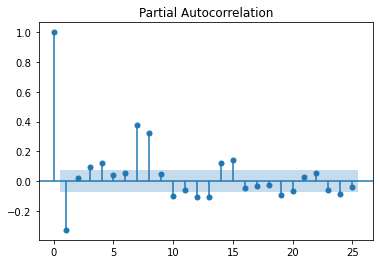

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf_var_confirmed = plot_pacf(df_diff_1['Confirmed'], lags=25)

In [19]:
def MAPE(Y_actual, Y_Predicted, title=None):
    mask = Y_actual != 0
    
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual)[mask])*100
    if title:
        print(f"MAPE of {title} is {mape[mape.index[0]]}%")
    return mape

In [20]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# evaluate an VARMA model for a given order (p,d,q)
def evaluate_varma_model(train, test, varma_order, column):
    
    model = VARMAX(train, order=varma_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(len(test))
    mse = mean_squared_error(test[column], yhat[column])
    mape = MAPE(test[column], yhat[column])
    mae = mean_absolute_error(test[column], yhat[column])
    return mse, mape, mae

In [21]:
# Grid search

# evaluate combinations of p and q values for an VARMA model
def evaluate_models(train, test, p_values, q_values, column):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = {'mse': float("inf")}, None
    
    for p in p_values:
        for q in q_values:
            order = (p,q)
            try:
                mse, mape, mae = evaluate_varma_model(train, test, order, column)
                
                if mse < best_score['mse']:
                    best_score['mse'], best_cfg = mse, order
                
                print('VARMA%s MSE=%.3f, MAPE=%.3f, MAE=%.3f' % (order,mse,mape,mae))
            except:
                continue
    print()
    print('Best VARMA%s MSE=%.3f' % (best_cfg, best_score['mse']))

In [22]:
evaluate_models(train, test, [1, 9], [0], column='Confirmed')

/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


VARMA(1, 0) MSE=63394609.791, MAPE=100.120, MAE=4163.653


/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


VARMA(9, 0) MSE=63599806.058, MAPE=94.738, MAE=4090.974

Best VARMA(1, 0) MSE=63394609.791


<a name=var1></a>
## VAR(1) Model

In [23]:
model = VARMAX(train, order=(1,0))
model_fit = model.fit()
forecasted = model_fit.forecast(len(test))

df_forecast = pd.DataFrame(forecasted, index=test.index)
df_forecast.rename(columns = {'Confirmed': 'Confirmed_forecast', 'Total_Doses': 'Total_Doses_forecast'}, inplace=True)

forecasted_conf = df_forecast.join(test)[['Confirmed', 'Confirmed_forecast']]
forecasted_vacc = df_forecast.join(test)[['Total_Doses', 'Total_Doses_forecast']]

# conf = model_fit.conf_int(alpha=0.05)

/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [24]:
model_fit.summary()

Dep. Variable:,"['Confirmed', 'Total_Doses']",No. Observations:,639
Model:,VAR(1),Log Likelihood,-16947.016
,+ intercept,AIC,33912.032
Date:,"Tue, 25 Jan 2022",BIC,33952.171
Time:,18:30:21,HQIC,33927.613
Sample:,01-31-2020,,
,- 10-30-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.18, 28.83",Jarque-Bera (JB):,"70450.69, 3940.03"
Prob(Q):,"0.67, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"2.98, 10591.64",Skew:,"2.58, 0.61"


<a name=diff_plot_var></a>

## Plots of Predictions (Differenced)

In [25]:
def plot_fore_test(test, fore, title):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)

    ax.plot(test, color='blue', label='Test')
    ax.plot(fore, color='red', label='Forecast')
    ax.legend(loc='best')
    plt.title(title)
    plt.show()

In [26]:
# plot_fore_test(test[['Confirmed']], forecasted[['Confirmed']], title='Diffed Daily cases')

In [27]:
# plot_fore_test(test[['Total_Doses']], forecasted[['Total_Doses']], title='Diffed Daily vaccinations')

<a name=undiff_var></a>

## Un-differencing and Plotting

In [28]:
def invert_transformation(diffed, original):
    """Revert back the differencing to get the forecast to original scale."""
    df_copy = original.copy()
    
    columns = diffed.columns
    
    for col in columns:
        # Add corresponding diff column
        df_copy[f'undiff_{col}'] = original[col]
        df_copy[f'undiff_{col}'][1:] = diffed[col]
        df_copy[f'undiff_{col}'] = df_copy[f'undiff_{col}'].cumsum()
    
        df_copy.drop(col, axis=1, inplace=True)
        
    return df_copy

In [29]:
# Check if un-diffed df_diff_1 is the same as original

#inverted = invert_transformation(df_diff_1, indexed)
#(inverted[['undiff_Confirmed']] - indexed[['Confirmed']]).isna().sum()

In [30]:
# Un-diff the test dataset

start_index = indexed.index.get_loc(test.index[0])-1
test_original = invert_transformation(test, indexed.iloc[start_index:])

#test_original

In [31]:
renamed_df = df_forecast.rename(columns={'Confirmed_forecast': 'Confirmed', 'Total_Doses_forecast': 'Total_Doses'}, inplace=False)


start_index = indexed.index.get_loc(renamed_df.index[0])-1
fore_original = invert_transformation(renamed_df, indexed.iloc[start_index:])

In [32]:
end_index = indexed.index.get_loc(fore_original.index[0])
train_original = indexed[:end_index]
# plot_2col_subplots([train_original, fore_original])

<a name=store_var></a>

## Store metrics

In [33]:
results_table = results_table.append({
    'model': 'VAR(1)',
    'mse': mean_squared_error(test_original['undiff_Confirmed'], fore_original['undiff_Confirmed']),
    'mape': MAPE(test_original['undiff_Confirmed'], fore_original['undiff_Confirmed']),
    'mae': mean_absolute_error(test_original['undiff_Confirmed'], fore_original['undiff_Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(1),1.500046e+09,56.212082,15872.635062


<a name=plot_final_var></a>

## Plot Train, Test, Forecast

In [34]:
def plot_train_test_fore(train, test, fore, conf=None, title='Forecast vs Actuals', ylabel='', xlabel='Date', figpath=None):
    
    # Confidence of cases
    if conf is not None:
        lower_series = pd.Series(conf[:, 0], index=val.index)
        upper_series = pd.Series(conf[:, 1], index=val.index)
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
        
    
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fore, label='forecast')
    fig = plt.gcf()
    
    plt.xlabel=xlabel
    plt.ylabel=ylabel

    plt.title(title)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    
    if figpath is not None:
        fig.savefig(figpath, format='eps', bbox_inches='tight')

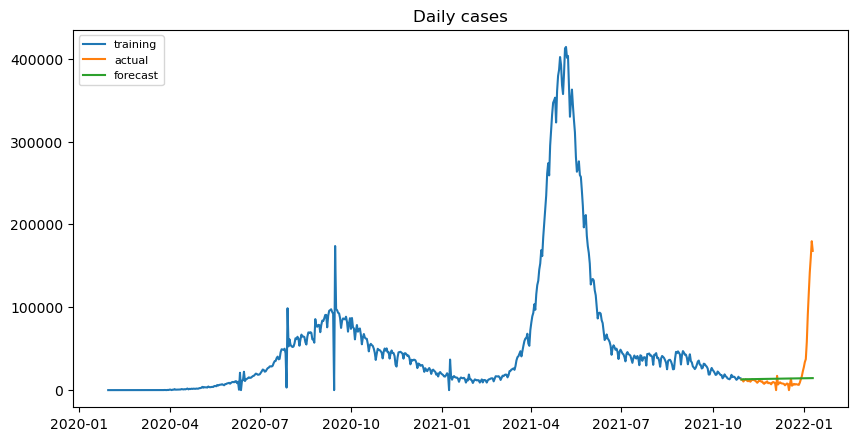

In [35]:
# Plot of daily cases
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original[['undiff_Confirmed']], title='Daily cases')


Clearly, a VAR model is not good enough to make predictions

In [36]:
# Plot of daily doses
#plot_train_test_fore(train_original.Total_Doses, test_original[['undiff_Total_Doses']], fore_original[['undiff_Total_Doses']], title='Daily doses', figpath='../../figures/v_ar/india_vacc.eps')


<a name=vma_model></a>

# VMA Model

<a name=vma_q></a>
## Find order q of VMA

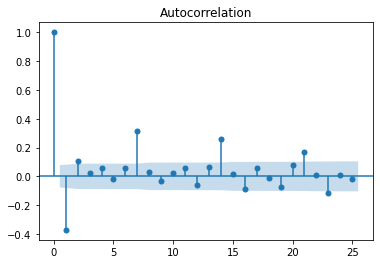

In [37]:
acf_varma_confirmed = plot_acf(train['Confirmed'], lags=25)

In [38]:
evaluate_models(train, test, [0], [1, 7], column='Confirmed')

/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


VARMA(0, 1) MSE=63383499.251, MAPE=104.266, MAE=4169.419


/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


VARMA(0, 7) MSE=63588961.622, MAPE=136.067, MAE=4244.623

Best VARMA(0, 1) MSE=63383499.251


<a name=vma1></a>

## VMA(1)

In [39]:
model_ma = VARMAX(train, order=(0,1))
model_fit_ma = model_ma.fit()
forecasted_ma = model_fit_ma.forecast(len(test))

df_forecast_ma = pd.DataFrame(forecasted_ma, index=test.index)
df_forecast_ma.rename(columns = {'Confirmed': 'Confirmed_forecast', 'Total_Doses': 'Total_Doses_forecast'}, inplace=True)

forecasted_conf_ma = df_forecast_ma.join(test)[['Confirmed', 'Confirmed_forecast']]
forecasted_vacc_ma = df_forecast_ma.join(test)[['Total_Doses', 'Total_Doses_forecast']]

# conf = model_fit.conf_int(alpha=0.05)

/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [40]:
model_fit_ma.summary()

Dep. Variable:,"['Confirmed', 'Total_Doses']",No. Observations:,639
Model:,VMA(1),Log Likelihood,-16880.069
,+ intercept,AIC,33778.138
Date:,"Tue, 25 Jan 2022",BIC,33818.278
Time:,18:30:39,HQIC,33793.719
Sample:,01-31-2020,,
,- 10-30-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"1.90, 18.44",Jarque-Bera (JB):,"78279.44, 5008.26"
Prob(Q):,"0.17, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"2.88, 662.89",Skew:,"2.79, 1.55"


<a name=diff_plot_vma></a>

## Plots of Predictions (Differenced)

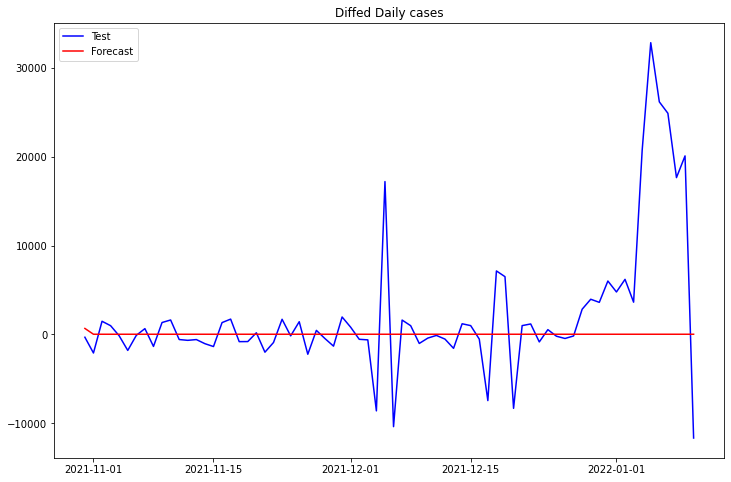

In [41]:
plot_fore_test(test[['Confirmed']], forecasted_ma[['Confirmed']], title='Diffed Daily cases')

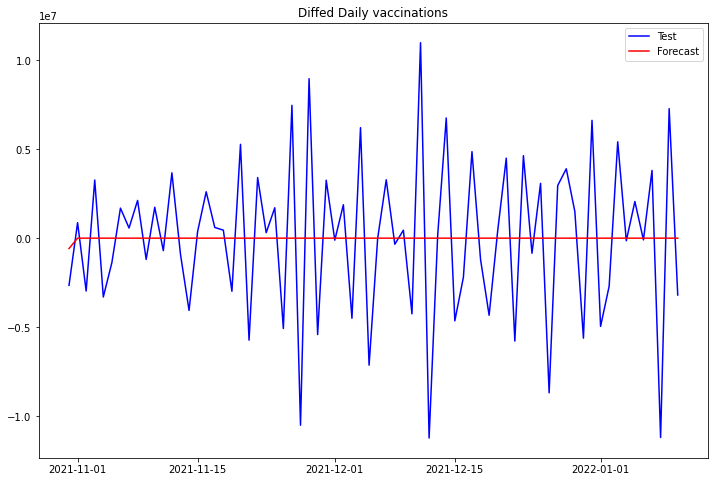

In [42]:
plot_fore_test(test[['Total_Doses']], forecasted_ma[['Total_Doses']], title='Diffed Daily vaccinations')

<a name=undiff_vma></a>

## Undifferencing and plotting

In [43]:
renamed_df_ma = df_forecast_ma.rename(columns={'Confirmed_forecast': 'Confirmed', 'Total_Doses_forecast': 'Total_Doses'}, inplace=False)


start_index_ma = indexed.index.get_loc(renamed_df_ma.index[0])-1
fore_original_ma = invert_transformation(renamed_df_ma, indexed.iloc[start_index_ma:])

In [44]:
fore_original_ma

,undiff_Confirmed,undiff_Total_Doses
Date,,
2021-10-30,12830.000000,6.780798e+06
2021-10-31,13503.265911,6.210082e+06
2021-11-01,13523.344158,6.220693e+06
2021-11-02,13543.422406,6.231305e+06
2021-11-03,13563.500653,6.241916e+06
...,...,...
2022-01-06,14848.508490,6.921057e+06
2022-01-07,14868.586738,6.931669e+06
2022-01-08,14888.664985,6.942280e+06


<a name=store_vma></a>

## Store metrics

In [45]:
results_table = results_table.append({
    'model': 'VMA(1)',
    'mse': mean_squared_error(test_original['undiff_Confirmed'], fore_original_ma['undiff_Confirmed']),
    'mape': MAPE(test_original['undiff_Confirmed'], fore_original_ma['undiff_Confirmed']),
    'mae': mean_absolute_error(test_original['undiff_Confirmed'], fore_original_ma['undiff_Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(1),1.500046e+09,56.212082,15872.635062
1,VMA(1),1.492894e+09,60.004170,16149.503426


In [46]:
# end_index = indexed.index.get_loc(fore_original_ma.index[0])
# train_original_ma = indexed[:end_index]
# #plot_subplots([train_original, fore_original_ma])

<a name=plot_final_vma></a>

## Plot Train, Test, Forecast

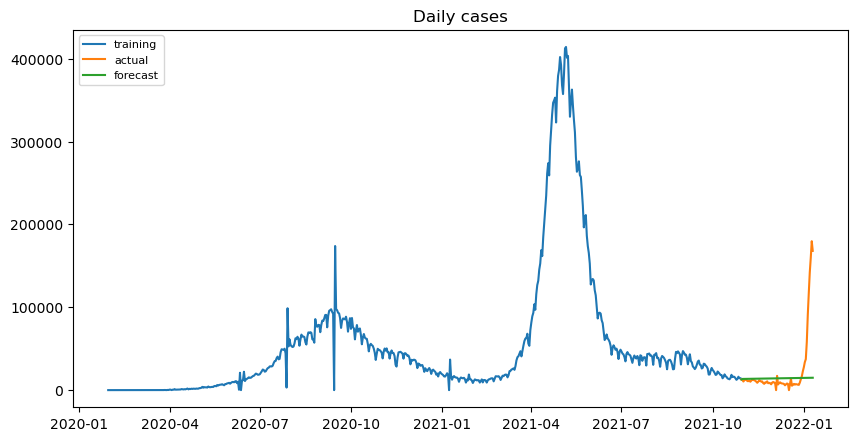

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [47]:
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original_ma[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/v_ar/india_cases.eps')


<a name=varma_model></a>

# VARMA

<a name=varma_pq></a>

## Find order (p, q) of VARMA

PACF/ACF

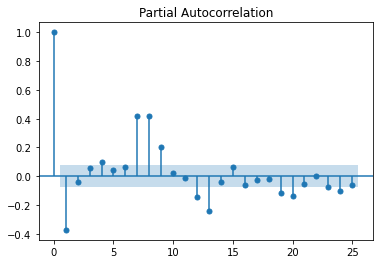

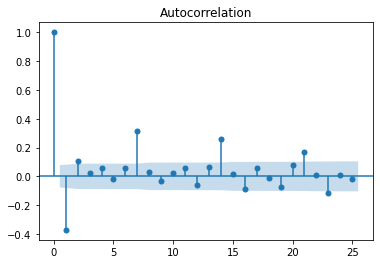

In [48]:
pacf_varma_confirmed = plot_pacf(train['Confirmed'], lags=25)
acf_varma_confirmed = plot_acf(train['Confirmed'], lags=25)

VARIMA(1, 1), VARIMA(9, 1), VARIMA(1, 7), VARIMA(9, 7)

In [49]:
evaluate_models(train, test, [1, 9], [1, 7], column='Confirmed')

/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No fre

VARMA(1, 1) MSE=63351046.433, MAPE=102.681, MAE=4161.262


/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


VARMA(1, 7) MSE=63397097.728, MAPE=132.116, MAE=4174.047


/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


VARMA(9, 1) MSE=63635258.787, MAPE=94.699, MAE=4090.721


/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


VARMA(9, 7) MSE=63617311.113, MAPE=97.724, MAE=4082.820

Best VARMA(1, 1) MSE=63351046.433


<a name=varma11></a>

## VARMA(1, 1)

In [50]:
model = VARMAX(train, order=(1,1))
model_fit = model.fit()
yhat = model_fit.forecast(len(test))
#yhat

/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<a name=diff_plot_varma></a>

## Plots of Predictions (Differenced)

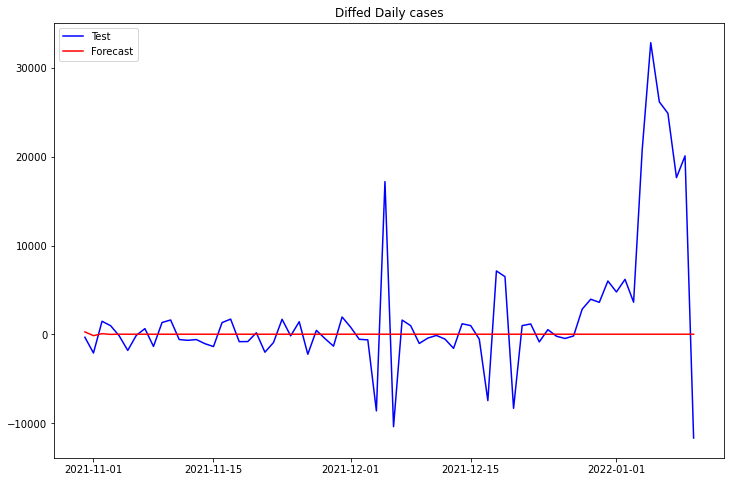

In [51]:
plot_fore_test(test[['Confirmed']], yhat[['Confirmed']], title='Diffed Daily cases')

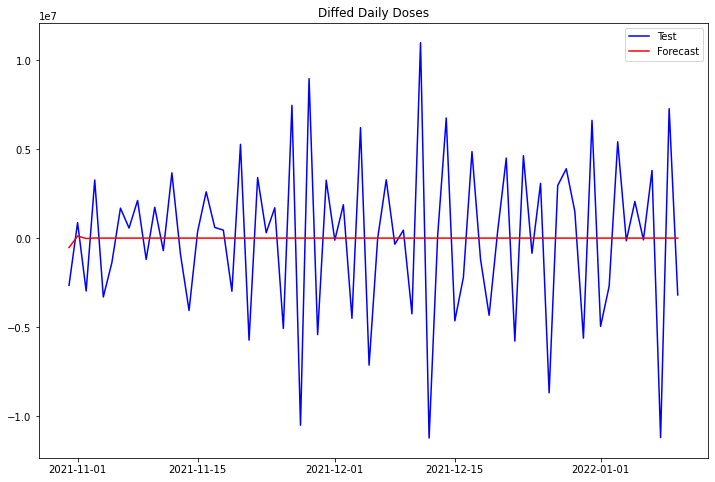

In [52]:
plot_fore_test(test[['Total_Doses']], yhat[['Total_Doses']], title='Diffed Daily Doses')

<a name=undiff_varma></a>

## Undifferencing and plotting

In [53]:
# Un-diff the test dataset

fore_original_3 = invert_transformation(yhat, indexed.iloc[start_index:])
fore_original_3

,undiff_Confirmed,undiff_Total_Doses
Date,,
2021-10-30,12830.000000,6.780798e+06
2021-10-31,13118.287700,6.262925e+06
2021-11-01,12978.773332,6.391139e+06
2021-11-02,13061.046842,6.381072e+06
2021-11-03,13065.924233,6.400066e+06
...,...,...
2022-01-06,14547.263936,7.296326e+06
2022-01-07,14570.346666,7.310343e+06
2022-01-08,14593.429395,7.324360e+06


In [54]:
#plot_fore_test(test_original[['undiff_Confirmed']], fore_original_3[['undiff_Confirmed']], title='Daily cases')

In [55]:
#plot_fore_test(test_original[['undiff_Total_Doses']], fore_original_3[['undiff_Total_Doses']], title='Daily Doses')

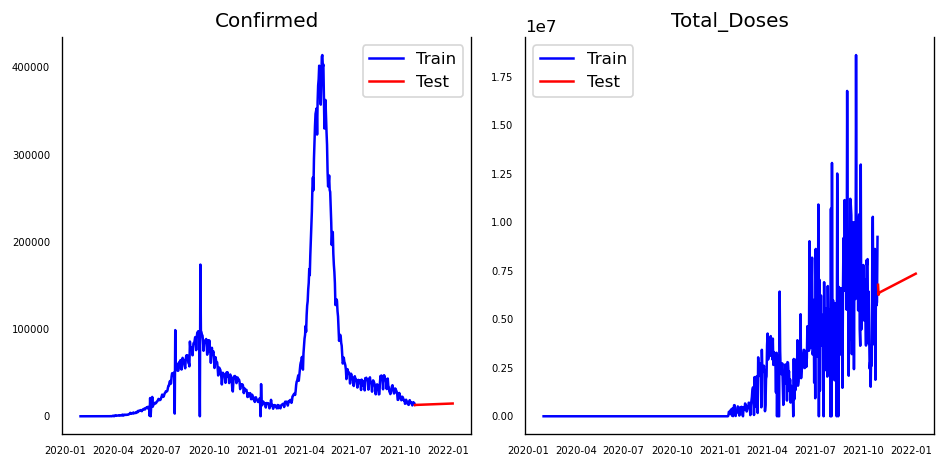

In [56]:
plot_2col_subplots([train_original, fore_original_3])

<a name=store_varma></a>

## Store metrics

In [57]:
results_table = results_table.append({
    'model': 'VARMA(1,1)',
    'mse': mean_squared_error(test_original['undiff_Confirmed'], fore_original_3['undiff_Confirmed']),
    'mape': MAPE(test_original['undiff_Confirmed'], fore_original_3['undiff_Confirmed']),
    'mae': mean_absolute_error(test_original['undiff_Confirmed'], fore_original_3['undiff_Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(1),1.500046e+09,56.212082,15872.635062
1,VMA(1),1.492894e+09,60.004170,16149.503426
2,"VARMA(1,1)",1.496983e+09,56.464454,15871.593152


<a name=plot_final_varma></a>

## Plot Train, Test, Forecast

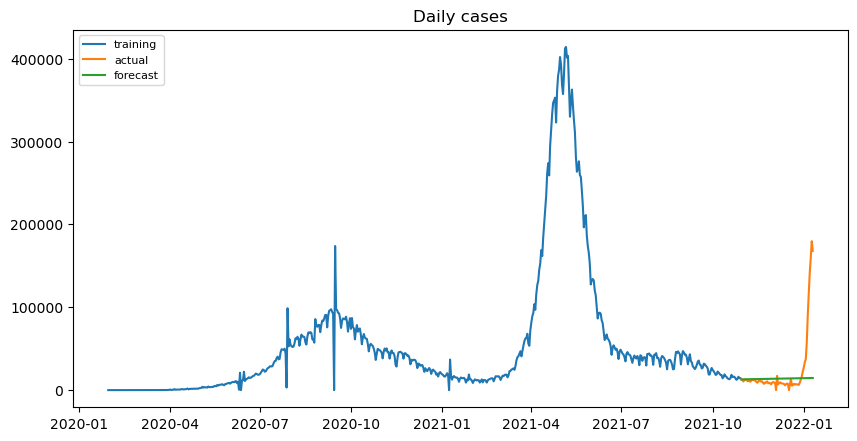

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [58]:
# Plot of daily cases
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original_3[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/varma/india_cases.eps')


In [59]:
# Plot of daily doses
# plot_train_test_fore(train_original.Total_Doses, test_original[['undiff_Total_Doses']], fore_original_3[['undiff_Total_Doses']], title='Daily cases', figpath='../../figures/varma/india_vacc.eps')

<a name=shortterm></a>

# Rolling forecasts

In [83]:
history = train.copy()
predicted = pd.DataFrame(columns=[
    'VAR_Confirmed', 
    'VAR_Total_Doses', 
    'VMA_Confirmed', 
    'VMA_Total_Doses', 
    'VARMA_Confirmed', 
    'VARMA_Total_Doses'
], index=test.index)


# predicted

for t in range(len(test)):
    # 3 models
    var = VARMAX(history, order=(8,0))
    vma = VARMAX(history, order=(0,7))
    varma = VARMAX(history, order=(8,7))
    
    # 3 fitted models
    var_fit = var.fit()
    vma_fit = vma.fit()
    varma_fit = varma.fit()
    
    # Predictions
    yhat_var = var_fit.forecast()
    yhat_vma = vma_fit.forecast()
    yhat_varma = varma_fit.forecast()
    
    # Next index to insert
    newindex = history.index[-1] + pd.to_timedelta(1, 'D')
    
    # Confirmed cases
    predicted.loc[newindex]['VAR_Confirmed'] = yhat_var['Confirmed'].values[0]
    predicted.loc[newindex]['VMA_Confirmed'] = yhat_vma['Confirmed'].values[0]
    predicted.loc[newindex]['VARMA_Confirmed'] = yhat_varma['Confirmed'].values[0]
    
    # Total doses
    predicted.loc[newindex]['VAR_Total_Doses'] = yhat_var['Total_Doses'].values[0]
    predicted.loc[newindex]['VMA_Total_Doses'] = yhat_vma['Total_Doses'].values[0]
    predicted.loc[newindex]['VARMA_Total_Doses'] = yhat_varma['Total_Doses'].values[0]
    
    history = history.append(test.iloc[t])
    # history[newindex]['Total_Doses'] = test.iloc[t]['Total_Doses']
    
    # print('predicted =', yhat.values, ' ; actual =', test.iloc[t].values)

/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


KeyboardInterrupt: 

In [63]:
predicted

,VAR_Confirmed,VAR_Total_Doses,VMA_Confirmed,VMA_Total_Doses,VARMA_Confirmed,VARMA_Total_Doses
Date,,,,,,
2021-10-31,-417.67578,-122933.14921,971.944533,1085075.317155,81.383138,-300411.970051
2021-11-01,-1940.122403,2164309.409751,-5085.507341,1488792.68542,-1933.616914,2166326.513962
2021-11-02,-162.360027,904740.494254,3501.05563,-49213.236496,-431.174469,802333.9043
2021-11-03,-204.41421,4061899.349339,719.457607,1546520.207952,-1270.085964,4236677.140991
2021-11-04,-567.966875,-528628.437064,145.543043,-1334515.843826,-1309.75701,-260406.063495
...,...,...,...,...,...,...
2022-01-06,-18962.868429,-3640584.417233,-6078.876284,-918949.238004,-17740.436651,-3567532.695614
2022-01-07,-15461.571123,-1588640.932641,2107.390282,676570.293181,-12531.615832,-1620084.855167
2022-01-08,-8137.499328,-5372063.087052,-149.512376,-1716033.116252,-529.112892,-5088107.447896


<a name=var_roll></a>

## VAR(1)

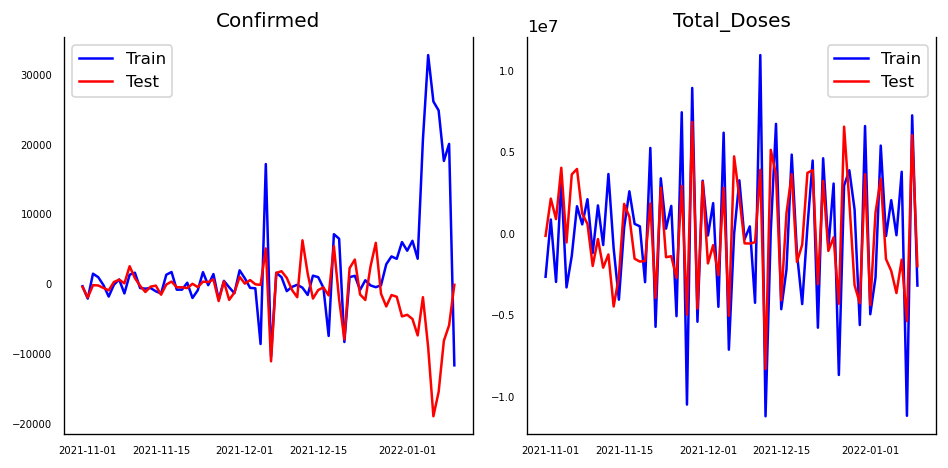

In [65]:
plot_2col_subplots([test, predicted[['VAR_Confirmed', 'VAR_Total_Doses']]])

In [66]:
# Un-diffing

pred_var = predicted[['VAR_Confirmed', 'VAR_Total_Doses']].rename(columns={'VAR_Confirmed': 'Confirmed', 'VAR_Total_Doses': 'Total_Doses'}, inplace=False)
fore_original_4_var = invert_transformation(pred_var, indexed.iloc[start_index:])

In [67]:
# fore_original_4_var

In [68]:
results_table = results_table.append({
    'model': 'VAR(9) - rolling',
    'mse': mean_squared_error(test_original['undiff_Confirmed'], fore_original_4_var['undiff_Confirmed']),
    'mape': MAPE(test_original['undiff_Confirmed'], fore_original_4_var['undiff_Confirmed']),
    'mae': mean_absolute_error(test_original['undiff_Confirmed'], fore_original_4_var['undiff_Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(1),1.500046e+09,56.212082,15872.635062
1,VMA(1),1.492894e+09,60.004170,16149.503426
2,"VARMA(1,1)",1.496983e+09,56.464454,15871.593152
3,VAR(1) - rolling,3.899712e+09,50.552477,22990.881312


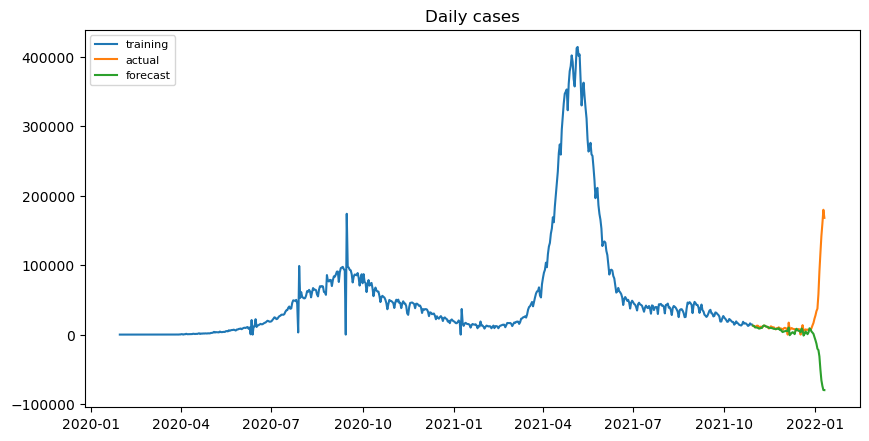

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [69]:
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original_4_var[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/varma/india_cases.eps')


<a name=vma_roll></a>

## VMA(1)

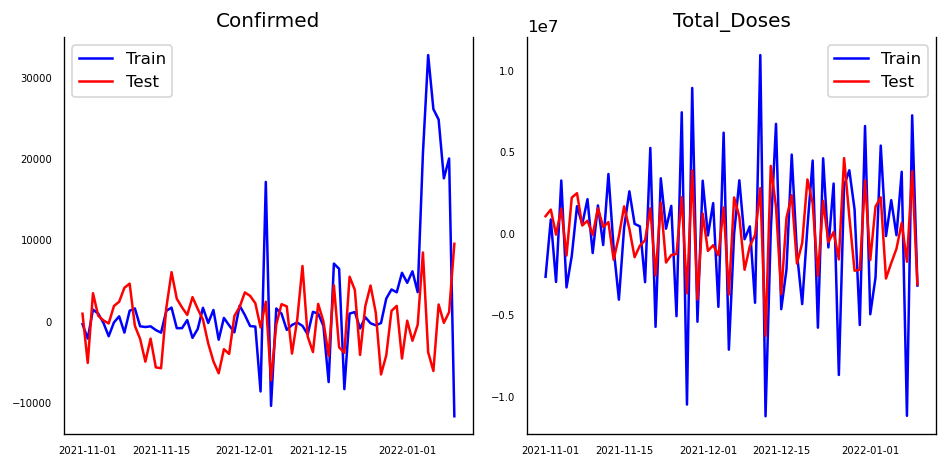

In [71]:
plot_2col_subplots([test, predicted[['VMA_Confirmed', 'VMA_Total_Doses']]])

In [72]:
# Un-diffing

pred_vma = predicted[['VMA_Confirmed', 'VMA_Total_Doses']].rename(columns={'VMA_Confirmed': 'Confirmed', 'VMA_Total_Doses': 'Total_Doses'}, inplace=False)
fore_original_4_vma = invert_transformation(pred_vma, indexed.iloc[start_index:])

In [73]:
# fore_original_4_vma

In [74]:
results_table = results_table.append({
    'model': 'VMA(7) - rolling',
    'mse': mean_squared_error(test_original['undiff_Confirmed'], fore_original_4_vma['undiff_Confirmed']),
    'mape': MAPE(test_original['undiff_Confirmed'], fore_original_4_vma['undiff_Confirmed']),
    'mae': mean_absolute_error(test_original['undiff_Confirmed'], fore_original_4_vma['undiff_Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(1),1.500046e+09,56.212082,15872.635062
1,VMA(1),1.492894e+09,60.004170,16149.503426
2,"VARMA(1,1)",1.496983e+09,56.464454,15871.593152
3,VAR(1) - rolling,3.899712e+09,50.552477,22990.881312
4,VMA(1) - rolling,1.730575e+09,59.030013,17591.242450


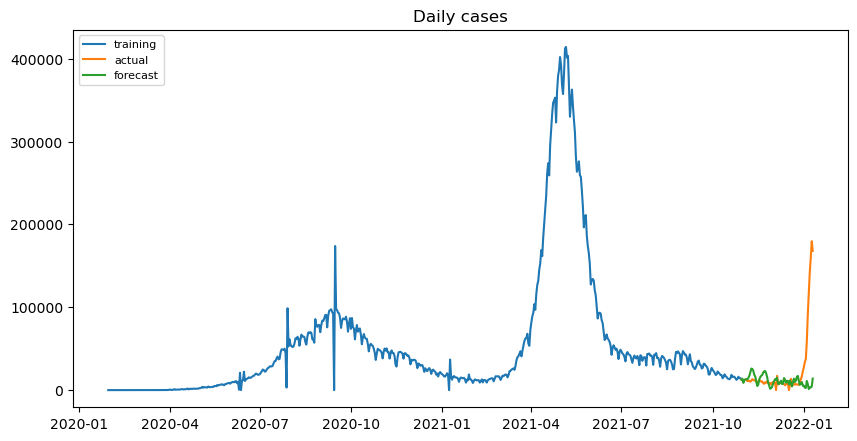

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [75]:
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original_4_vma[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/varma/india_cases_vma.eps')



<a name=varma_roll></a>

## VARMA(1,1)

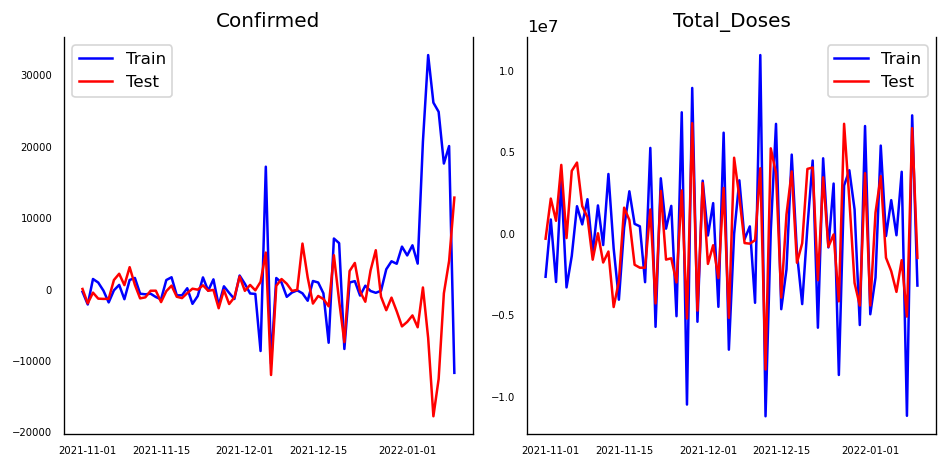

In [77]:
plot_2col_subplots([test, predicted[['VARMA_Confirmed', 'VARMA_Total_Doses']]])

In [78]:
# Un-diffing

pred_varma = predicted[['VARMA_Confirmed', 'VARMA_Total_Doses']].rename(columns={'VARMA_Confirmed': 'Confirmed', 'VARMA_Total_Doses': 'Total_Doses'}, inplace=False)
fore_original_4_varma = invert_transformation(pred_varma, indexed.iloc[start_index:])

In [79]:
# fore_original_4_varma

In [80]:
results_table = results_table.append({
    'model': 'VARMA(9, 7) - rolling',
    'mse': mean_squared_error(test_original['undiff_Confirmed'], fore_original_4_varma['undiff_Confirmed']),
    'mape': MAPE(test_original['undiff_Confirmed'], fore_original_4_varma['undiff_Confirmed']),
    'mae': mean_absolute_error(test_original['undiff_Confirmed'], fore_original_4_varma['undiff_Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(1),1.500046e+09,56.212082,15872.635062
1,VMA(1),1.492894e+09,60.004170,16149.503426
2,"VARMA(1,1)",1.496983e+09,56.464454,15871.593152
3,VAR(1) - rolling,3.899712e+09,50.552477,22990.881312
4,VMA(1) - rolling,1.730575e+09,59.030013,17591.242450
5,"VARMA(1, ) - rolling",3.092848e+09,49.686957,21003.941723


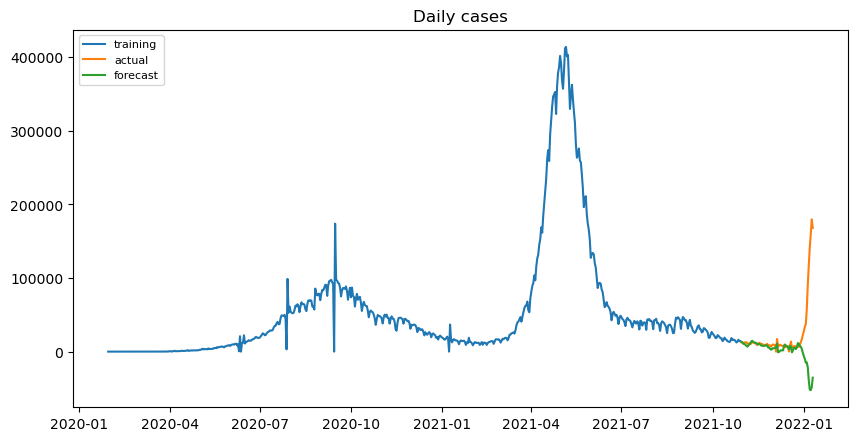

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [81]:
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original_4_varma[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/varma/india_cases_varma.eps')


<a name=final_results></a>

# Final Results

In [82]:
results_table

,model,mse,mape,mae
0,VAR(1),1.500046e+09,56.212082,15872.635062
1,VMA(1),1.492894e+09,60.004170,16149.503426
2,"VARMA(1,1)",1.496983e+09,56.464454,15871.593152
3,VAR(1) - rolling,3.899712e+09,50.552477,22990.881312
4,VMA(1) - rolling,1.730575e+09,59.030013,17591.242450
5,"VARMA(1, ) - rolling",3.092848e+09,49.686957,21003.941723
